In [ ]:
!git clone https://github.com/dovugiacan14/Image-Classification-CIFAR100.git

Cloning into 'Image-Classification-CIFAR100'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 119 (delta 65), reused 86 (delta 35), pack-reused 0 (from 0)
Receiving objects: 100% (119/119), 26.36 KiB | 5.27 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [ ]:
!pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing ins

In [ ]:
%%writefile /kaggle/working/Image-Classification-CIFAR100/config.py
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch_optimizer import Lookahead

device = "cuda" if torch.cuda.is_available() else "cpu"
save_dir = "checkpoints/"
os.makedirs(save_dir, exist_ok=True)
num_workers = 16


class CNNConfig:
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.001
    num_epochs = 100
    batch_size = 16
    device = device
    out_name = "cnn_model"
    os.makedirs(out_name, exist_ok= True)

    @staticmethod
    def optimizer_fn(model):
        return optim.Adam(model.parameters(), lr=CNNConfig.learning_rate)


class ResNetConfig:
    criterion = nn.CrossEntropyLoss()
    learning_rate = 1e-4
    weight_decay = 1e-4
    num_epochs = 100
    batch_size = 32
    device = device
    out_name = save_dir + "ResNet50/resnet50_model"
    num_workers = num_workers

    @staticmethod
    def optimizer_fn(model):
        return optim.AdamW(
            model.parameters(),
            lr=ResNetConfig.learning_rate,
            weight_decay=ResNetConfig.weight_decay,
        )

    @staticmethod
    def scheduler_fn(optimizer):
        return optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=ResNetConfig.num_epochs
        )


class VGGConfig:
    criterion = nn.CrossEntropyLoss()
    batch_size = 32
    num_epochs = 2
    learning_rate = 1e-4
    device = device
    out_name = "vgg16_model"

    @staticmethod
    def optimizer_fn(model):
        return optim.Adam(model.parameters(), lr=VGGConfig.learning_rate)


class DenseNetConfig:
    criterion = nn.CrossEntropyLoss()
    learning_rate = 1e-4
    weight_decay = 1e-4
    num_epochs = 100
    batch_size = 32
    device = device
    out_name = save_dir + "DenseNet/densenet121_model"

    @staticmethod
    def optimizer_fn(model):
        return optim.AdamW(
            model.parameters(),
            lr=DenseNetConfig.learning_rate,
            weight_decay=DenseNetConfig.weight_decay,
        )


class EfficientConfig:
    criterion = nn.CrossEntropyLoss()
    batch_size = 32
    num_epochs = 2
    learning_rate = 1e-4
    device = device
    out_name = "efficientnetb0_finetune_model"

    @staticmethod
    def optimizer_fn(model):
        return optim.Adam(model.parameters(), lr=EfficientConfig.learning_rate)


class ConvNeXtConfig:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    learning_rate = 3e-4
    num_epochs = 100
    batch_size = 32
    device = device
    out_name = save_dir + "ConvNeXt/convnext_tiny_model"
    grad_clip = 1.0  # gradient clipping value

    @staticmethod
    def optimizer_fn(model):
        base_opt = optim.AdamW(
            model.parameters(), lr=ConvNeXtConfig.learning_rate, weight_decay=1e-4
        )
        return Lookahead(base_opt)


class ViTConfig:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 2
    batch_size = 32
    learning_rate = 2e-5
    weight_decay = 0.01
    T_max = 10
    device = device
    out_name = "ViT_finetune_model"

    @staticmethod
    def optimizer_fn(model):
        return optim.AdamW(model.parameters(), lr=ViTConfig.learning_rate)

    @staticmethod
    def scheduler():
        return optim.lr_scheduler.CosineAnnealingLR(
            optimizer=ViTConfig.optimizer_fn, T_max=ViTConfig.T_max
        )


class SwinConfig:
    criterion = nn.CrossEntropyLoss()
    learning_rate = 2e-5
    weight_decay = 0.01
    num_epochs = 100
    batch_size = 32
    device = device
    out_name = save_dir + "SwinTransformer/swin_transformer_tiny_model"
    model_name = "microsoft/swin-tiny-patch4-window7-224"

    @staticmethod
    def optimizer_fn(model):
        return optim.AdamW(
            model.parameters(),
            lr=SwinConfig.learning_rate,
            weight_decay=SwinConfig.weight_decay,
        )

Overwriting /kaggle/working/Image-Classification-CIFAR100/config.py


In [ ]:
!python /kaggle/working/Image-Classification-CIFAR100/main.py --option 1

2025-05-31 12:56:20.012760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748696180.199267      63 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748696180.251763      63 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|████████████████████████████████████████| 169M/169M [00:15<00:00, 11.1MB/s]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 3

In [2]:
import re
import matplotlib.pyplot as plt

def show_train_accuracy_plot_from_file(filepath):
    # Đọc nội dung log từ file
    with open(filepath, 'r') as f:
        log_text = f.read()

    # Trích xuất Train Accuracy
    train_acc = [float(acc) for acc in re.findall(r"Train Acc: (\d+\.\d+)%", log_text)]
    epochs = list(range(1, len(train_acc) + 1))

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Train Accuracy (%)")
    plt.title("Training Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

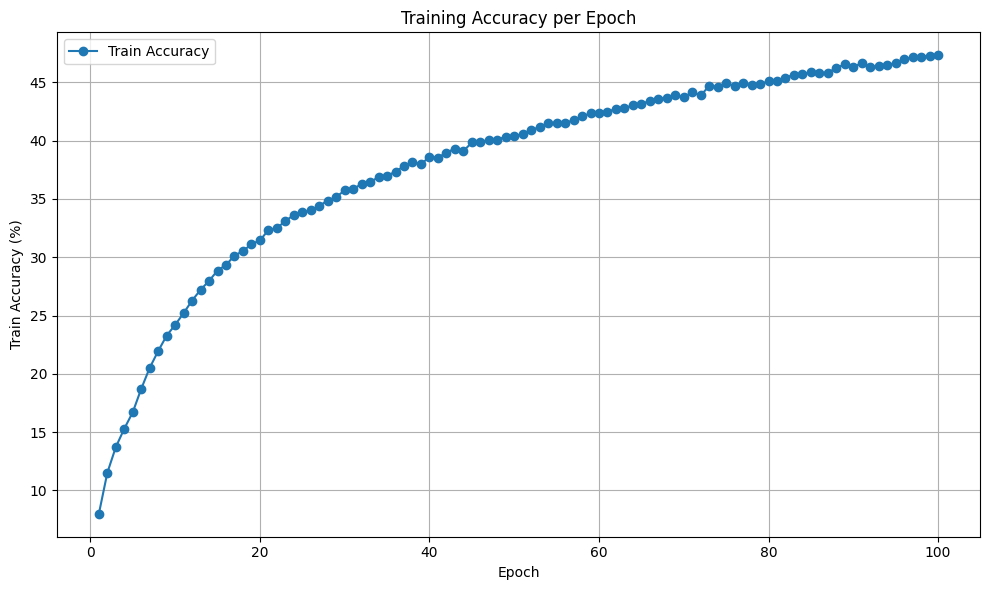

In [3]:
show_train_accuracy_plot_from_file("/content/drive/MyDrive/Master/CS2310.CH190/Lab2/Image-Classification-CIFAR100/training_logs/Lab2_Train_CNN.txt")